Mean of Erosion Volsum over count: -0.599597685773585
Standard Deviation of Erosion Volsum over count: 0.25038060518582317
Mean Squared Error: 0.05223814023245754


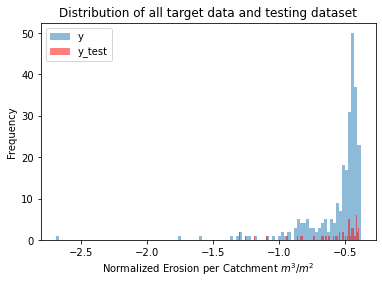

In [357]:
import RF_utils as rfut
from RF_feature_importance import evaluate_model_with_shap, evaluate_feature_with_shap  # Assuming SHAP evaluation is defined here
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
import pandas as pd
from sklearn.inspection import plot_partial_dependence
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import RFE
import pandas as pd
import seaborn as sns

# Load your data (modify this part with real data loading)
csv_fn = r"Y:\ATD\GIS\East_Troublesome\Watershed Statistical Analysis\Watershed Stats\Hillslopes\Stream Clipped Hillslopes Pruned\Hillslope_Stats_Combined 050224.csv"
variables_to_exclude = ['ID', 'Erosion mean', "Category",	"OBJECTID", "Deposition mean",	"Deposition stdev",	"Erosion stdev", "Watershed",
                    "Deposition mean Masked",	"Deposition stdev Masked",	"Erosion mean Masked",	"Erosion stdev Masked", 'Erosion Volsum Masked',	
                    'Erosion Volsum Masked Count',	'Erosion Volsum over count', 'Deposition Volsum Masked',	'Deposition Volsum Masked Count',  
                    'perimeter', "width", "length", 
                      "Mulch Coverage %"
                    # "Aspect Mean", "Aspect std",   "dummy", "% Bare Earth", , 
                    # "Slope Mean", "Slope std",  "Max Int 60 min", "Accumulated Precipitation", "area",
                    # "Terrain Ruggedness Index", "Flow Accumulation", "dNBR Mean", "Curvature", "width_over_length",
                    ] #
# #8                % Bare Earth        1
# 15   Terrain Ruggedness Index        1
# 5                   Slope std        1
# 16          Flow Accumulation        1
# 10  Accumulated Precipitation        1
# 9              Max Int 60 min        2
y_field = 'Erosion Volsum over count'
watershed_values = None

def load_data(file_path, exclude_vars, y_var):
    data = pd.read_csv(file_path)
    #drop rows where Erosion Volsum Masked Count is less than 10
    data = data[data['Erosion Volsum Masked Count'] >= 1]
    X = data.drop(columns=exclude_vars)
    y = data[y_var].dropna()
    #drop rows where y contains NaN
    y = y.dropna()
    X = X.loc[y.index]
    X = pd.get_dummies(X)  # Convert categorical columns to dummy variables
    y = y[y <= -0.196]
    X = X.loc[y.index]
    #log transform y
    # y = np.log(np.abs(y))
    return X, y


def recursive_feature_elimination(model, X, y, n_features_to_select=10):
    """
    Perform Recursive Feature Elimination (RFE) using a Random Forest classifier.
    
    Args:
    X (DataFrame): The feature set.
    y (Series): The target variable.
    n_features_to_select (int): The number of features to select.
    
    Returns:
    DataFrame: A DataFrame with feature rankings (1 is most important).
    """

    # Create the RFE model and select attributes
    rfe = RFE(estimator=model, n_features_to_select=n_features_to_select)
    rfe = rfe.fit(X, y)
    
    # Summarize the selection of the attributes
    feature_ranking = pd.DataFrame({'Feature': X.columns, 
                                    'Ranking': rfe.RFE_})
    
    return feature_ranking.sort_values('Ranking')

# Load and prepare data
# Using specific watershed data if watershed_value is defined, else load all data
X, y = load_data(csv_fn, variables_to_exclude, y_field)

#get log transform of X and y
#create a new column in X called dummy that is random noise
# Split the data into training and test sets
#rfut.tune_and_evaluate_model(X,y)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train the model
#model = RandomForestRegressor(n_estimators=350, max_depth=18, min_samples_split=5, random_state=42)
model = rfut.tune_model(X_train, y_train)
model.fit(X_train, y_train)
print(f"Mean of {y_field}: {y_test.mean()}")
print(f"Standard Deviation of {y_field}: {y_test.std()}")
mse, predictions = rfut.evaluate_model(model, X_test, y_test)
# Evaluate the model with SHAP
#evaluate_model_with_shap(model, X_train, X_test)

#make a data frame from y_test and predictions
df = pd.DataFrame(y_test)
#name the column y_field
df[y_field] = y_test
df['predictions'] = predictions
df_og = pd.DataFrame(y)
#plot histogram of y_test and y
plt.hist(df_og[y_field], bins=100, alpha=0.5, label='y')
plt.hist(df[y_field], bins=100, alpha=0.5, label='y_test', color='red')
plt.title(f'Distribution of all target data and testing dataset')
plt.xlabel(f'Normalized Erosion per Catchment $m^3/m^2$')
plt.ylabel('Frequency')
#add legend
plt.legend(loc='upper left')
plt.show()


In [358]:
from sklearn.feature_selection import RFECV
from sklearn.ensemble import RandomForestRegressor  # Assuming the model used is a random forest
from sklearn.model_selection import KFold
# Set up cross-validation
kf = KFold(n_splits=5, shuffle=True, random_state=42)
results = []
shap_DICT = {}
rfe_results = []

for train_index, test_index in kf.split(X):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    model.fit(X_train, y_train)

    mse, predictions = rfut.evaluate_model(model, X_test, y_test)
    predictions_series = pd.Series(predictions, index=y_test.index)
    R2 = y_test.corr(predictions_series)**2

    results.append({'MSE': mse, 'R2': R2, 'score': model.score(X_test, y_test)})

    RANKED_shap, _ = evaluate_model_with_shap(model, X_train, X_test, plot=False)
    for key in RANKED_shap['Feature']:
        shap_value = RANKED_shap['SHAP Importance'][RANKED_shap['Feature'] == key].values[0]
        if key in shap_DICT:
            shap_DICT[key].append(shap_value)
        else:
            shap_DICT[key] = [shap_value]

    # Perform Recursive Feature Elimination
    rfe = RFECV(estimator=model, step=1, cv=KFold(2), scoring='neg_mean_squared_error')
    rfe.fit(X_train, y_train)
    rfe_results.append(rfe.ranking_)


# Print summary of results
mean_R2 = np.mean([r['R2'] for r in results])
mean_MSE = np.mean([r['MSE'] for r in results])
mean_score = np.mean([r['score'] for r in results])
print("\n Model Evaluation Results:")
print(f"Average Score: {mean_score}")
print(f"Average R^2: {mean_R2}")
print(f"Average MSE: {mean_MSE}")
print(f"Number of training samples: {len(y_train)}")
print(f"Number of testing samples: {len(y_test)}")


Mean Squared Error: 0.05377263260581243
Mean Squared Error: 0.11357092380894976
Mean Squared Error: 0.018284767062284744
Mean Squared Error: 0.044187333617786276
Mean Squared Error: 0.048178611821571585

 Model Evaluation Results:
Average Score: 0.08846165102601855
Average R^2: 0.11782298816605308
Average MSE: 0.05559885378328096
Number of training samples: 210
Number of testing samples: 52


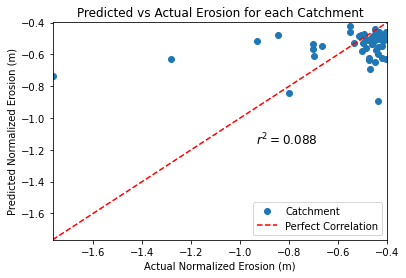

In [359]:
#make a data frame from y_test and predictions
df = pd.DataFrame(y_test)
#name the column y_field
df[y_field] = y_test
df['predictions'] = predictions
#plot the predictions vs y_test
plt.scatter(df[y_field], df['predictions'])
plt.xlabel('Actual Normalized Erosion (m)')
plt.ylabel('Predicted Normalized Erosion (m)')
#set axis to be the same bounds
plt.xlim(min(df[y_field]), max(df[y_field]))
plt.ylim(min(df[y_field]), max(df[y_field]))
#plot a perfect correlation line
plt.plot([min(df[y_field]), max(df[y_field])], [min(df[y_field]), max(df[y_field])], color='red', linestyle='--')
plt.title('Predicted vs Actual Erosion for each Catchment')

# Ensure you have defined the appropriate y_field in your DataFrame
y_min = min(df[y_field])
y_max = max(df[y_field])
x_min = min(df['predictions'])
x_max = max(df['predictions'])
x_position = x_min +x_min* 0.1 * (x_max - x_min)
y_position = y_max - 0.5 * (y_max - y_min)
plt.text(x_position, y_position, r"$r^2=    {:.3f}$".format(mean_score), fontsize=12, fontweight='bold',
         verticalalignment='top', horizontalalignment='left', backgroundcolor='white', color='black')

plt.legend(['Catchment', 'Perfect Correlation'], loc='lower right')

plt.show()

Feature Rankings from SHAP across folds::


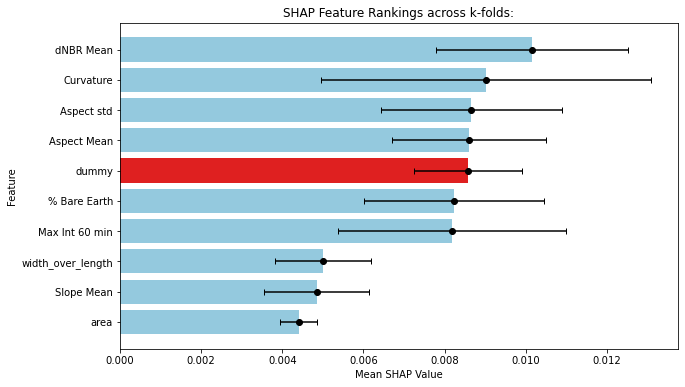

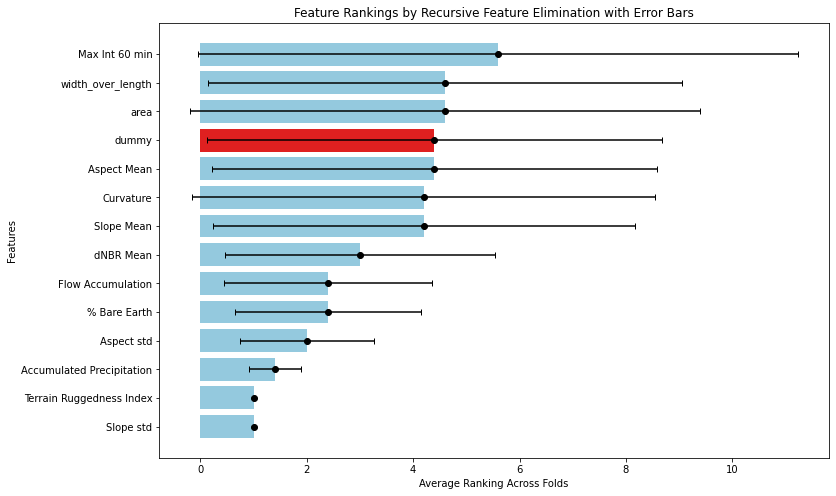

In [360]:
# Calculate mean and standard deviation of SHAP values
shap_mean_std = {key: {'mean': np.mean(vals), 'std': np.std(vals)} for key, vals in shap_DICT.items()}
# Convert shap_DICT to a DataFrame for plotting
shap_df = pd.DataFrame(list(shap_DICT.items()), columns=['Feature', 'SHAP Importances'])
shap_df['Mean SHAP'] = shap_df['SHAP Importances'].apply(np.mean)
shap_df = shap_df.sort_values(by='Mean SHAP', ascending=True)
shap_df = shap_df.reset_index(drop=True)
print("Feature Rankings from SHAP across folds::")
# Ensure you are working with a copy of the data to avoid SettingWithCopyWarning
top_features = shap_df.head(10).copy()

# Calculate standard deviations for error bars and assign color based on 'Feature'
top_features['STD Errors'] = top_features['SHAP Importances'].apply(np.std)
top_features['Color'] = ['red' if feature == 'dummy' else 'skyblue' for feature in top_features['Feature']]

# Sort the DataFrame to have the most important feature on top
top_features = top_features.sort_values(by='Mean SHAP', ascending=False).reset_index(drop=True)

# Create the plot using the modified DataFrame
plt.figure(figsize=(10, 6))
bar_plot = sns.barplot(x='Mean SHAP', y='Feature', data=top_features, palette=top_features['Color'])

# Iterate over the sorted DataFrame to place error bars correctly
for index, row in top_features.iterrows():
    # Error bars are plotted using the `index` which matches the new sorted order
    bar_plot.errorbar(row['Mean SHAP'], index, xerr=row['STD Errors'], fmt='o', color='black', capsize=3)

plt.xlabel('Mean SHAP Value')
plt.title('SHAP Feature Rankings across k-folds:')
plt.show()


# Aggregate RFE rankings across folds
feature_rankings = np.array(rfe_results)
mean_rankings = np.mean(feature_rankings, axis=0)
std_rankings = np.std(feature_rankings, axis=0)

# Create DataFrame for RFE results
rfe_df = pd.DataFrame({'Feature': X.columns, 'Mean RFE': mean_rankings, 'STD RFE': std_rankings})
rfe_df = rfe_df.sort_values(by='Mean RFE', ascending=True)
rfe_df['Color'] = ['red' if feature == 'dummy' else 'skyblue' for feature in rfe_df['Feature']]
rfe_df.reset_index(drop=True, inplace=True)

# Create the RFE plot
plt.figure(figsize=(12, 8))
rfe_bar_plot = sns.barplot(x='Mean RFE', y='Feature', data=rfe_df, palette=rfe_df['Color'])
for index, row in rfe_df.iterrows():
    rfe_bar_plot.errorbar(row['Mean RFE'], index, xerr=row['STD RFE'], fmt='o', color='black', capsize=3)
plt.xlabel('Average Ranking Across Folds')
plt.ylabel('Features')
plt.title('Feature Rankings by Recursive Feature Elimination with Error Bars')
#invert the y axis so the most important feature is at the top
plt.gca().invert_yaxis()
plt.show()

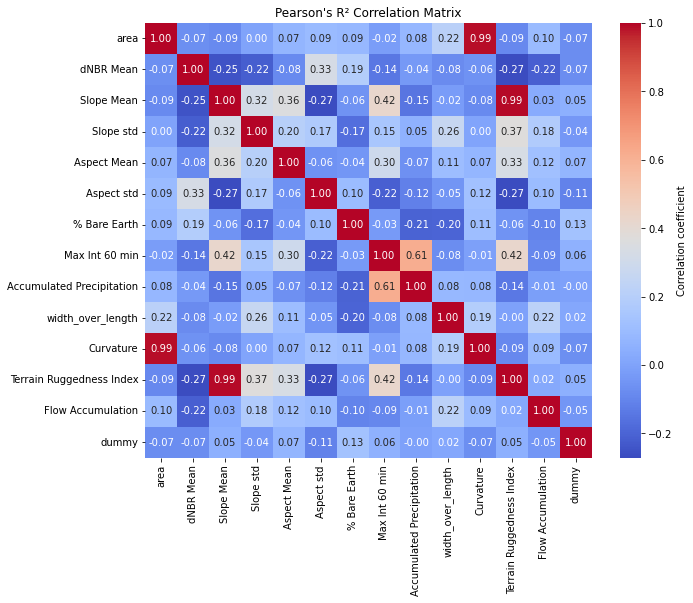

In [361]:

def correlation_matrix_table(features_df):
    """
    Calculate and display a correlation matrix with Pearson's R^2 for all features.

    Parameters:
    - features_df (pd.DataFrame): DataFrame containing all the features.

    Returns:
    - Displays a heatmap of the correlation matrix.
    """
    # Calculate the Pearson correlation matrix
    corr_matrix = features_df.corr()
    
    # Create a heatmap to visualize the correlation matrix
    plt.figure(figsize=(10, 8))
    sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm', cbar_kws={'label': 'Correlation coefficient'})
    plt.title("Pearson's R² Correlation Matrix")
    plt.show()

correlation_matrix_table(X_train)

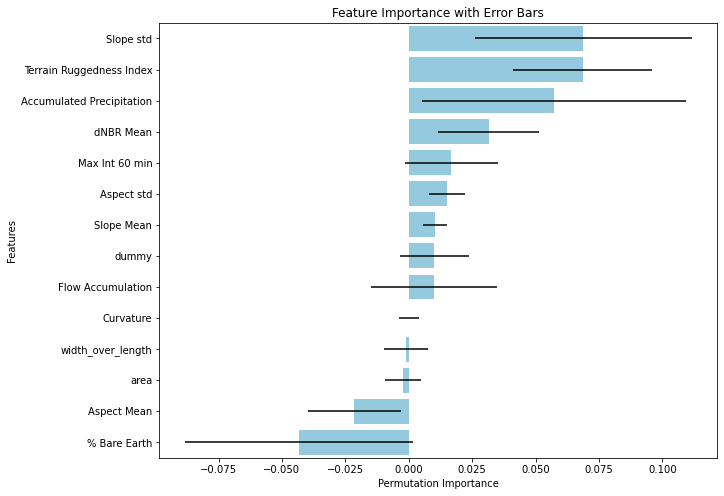

In [362]:
from sklearn.inspection import permutation_importance

# Assuming best_model, X_test, y_test are already defined
# Calculate permutation importance
perm_importance = permutation_importance(model, X_test, y_test, n_repeats=30, random_state=42)

# Prepare the data for plotting
importances = perm_importance.importances_mean[perm_importance.importances_mean.argsort()]
std = perm_importance.importances_std[perm_importance.importances_mean.argsort()]
features = X_test.columns[perm_importance.importances_mean.argsort()]

# Reverse the order so the most important feature is at the top
importance_data = pd.DataFrame({
    'Features': features[::-1],
    'Importances': importances[::-1],
    'Std': std[::-1]
})

# Plot using Seaborn
plt.figure(figsize=(10, 8))
sns.barplot(x='Importances', y='Features', data=importance_data, xerr=importance_data['Std'], color = 'skyblue')

plt.xlabel('Permutation Importance')
plt.title('Feature Importance with Error Bars')
plt.show()

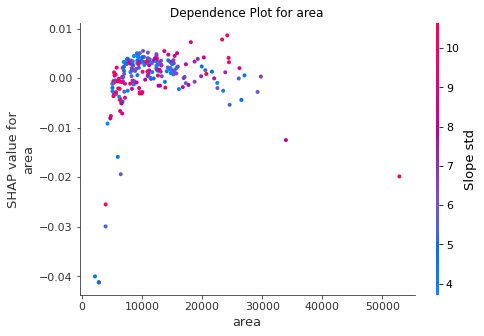

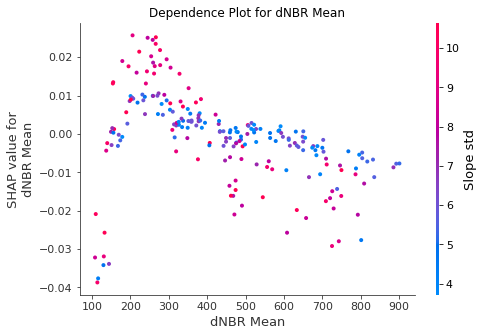

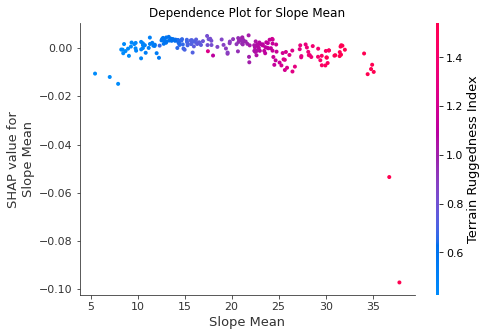

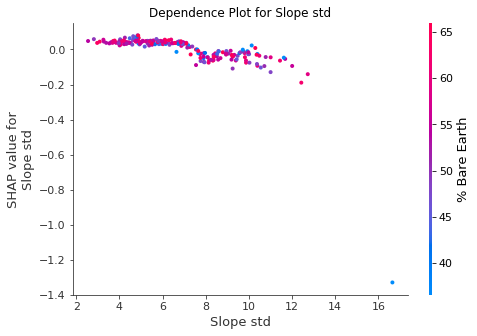

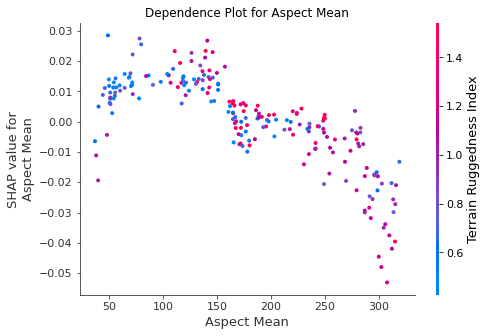

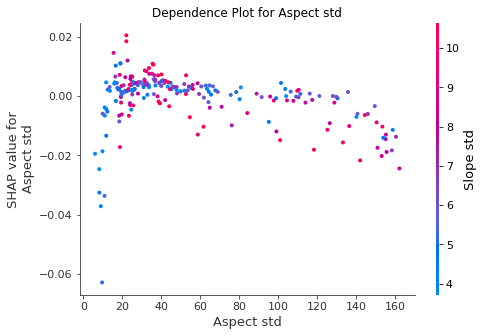

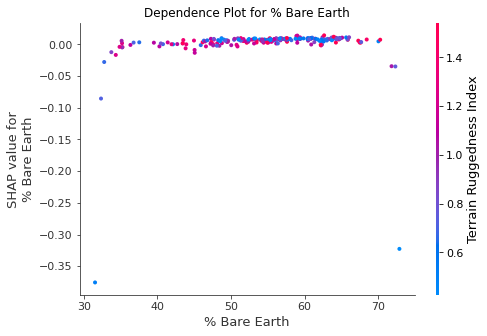

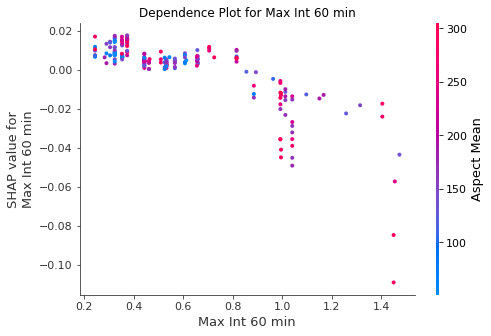

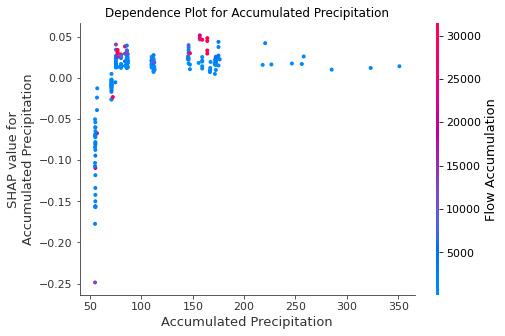

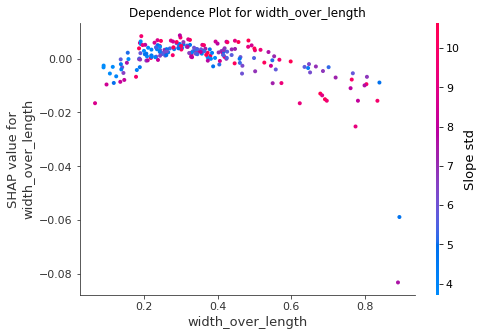

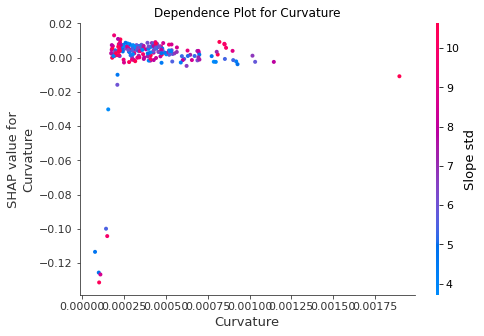

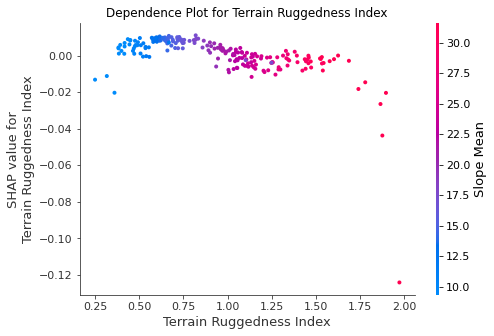

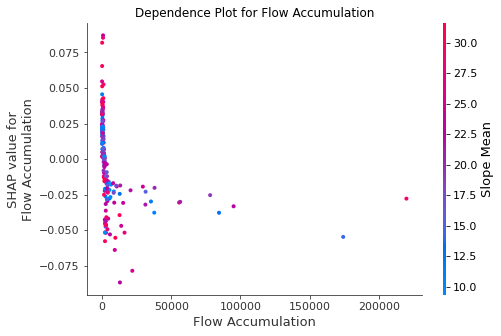

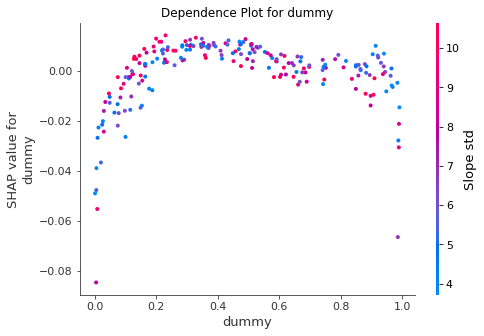

In [363]:
feature_labels = X.columns
for feature in feature_labels:
    # Create a pdp plot for each feature
    evaluate_feature_with_shap(model, X_train, X_test, feature)
    #plt.show()



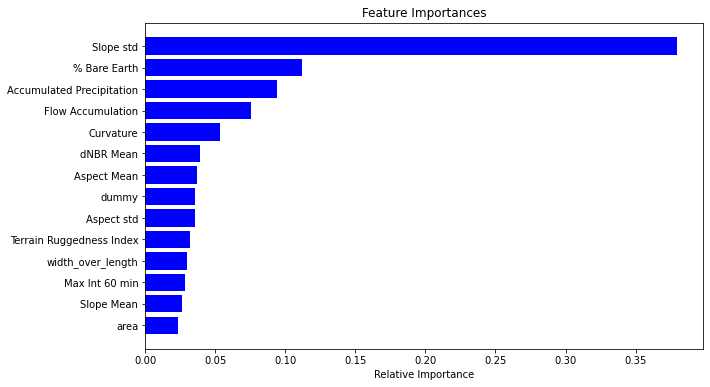

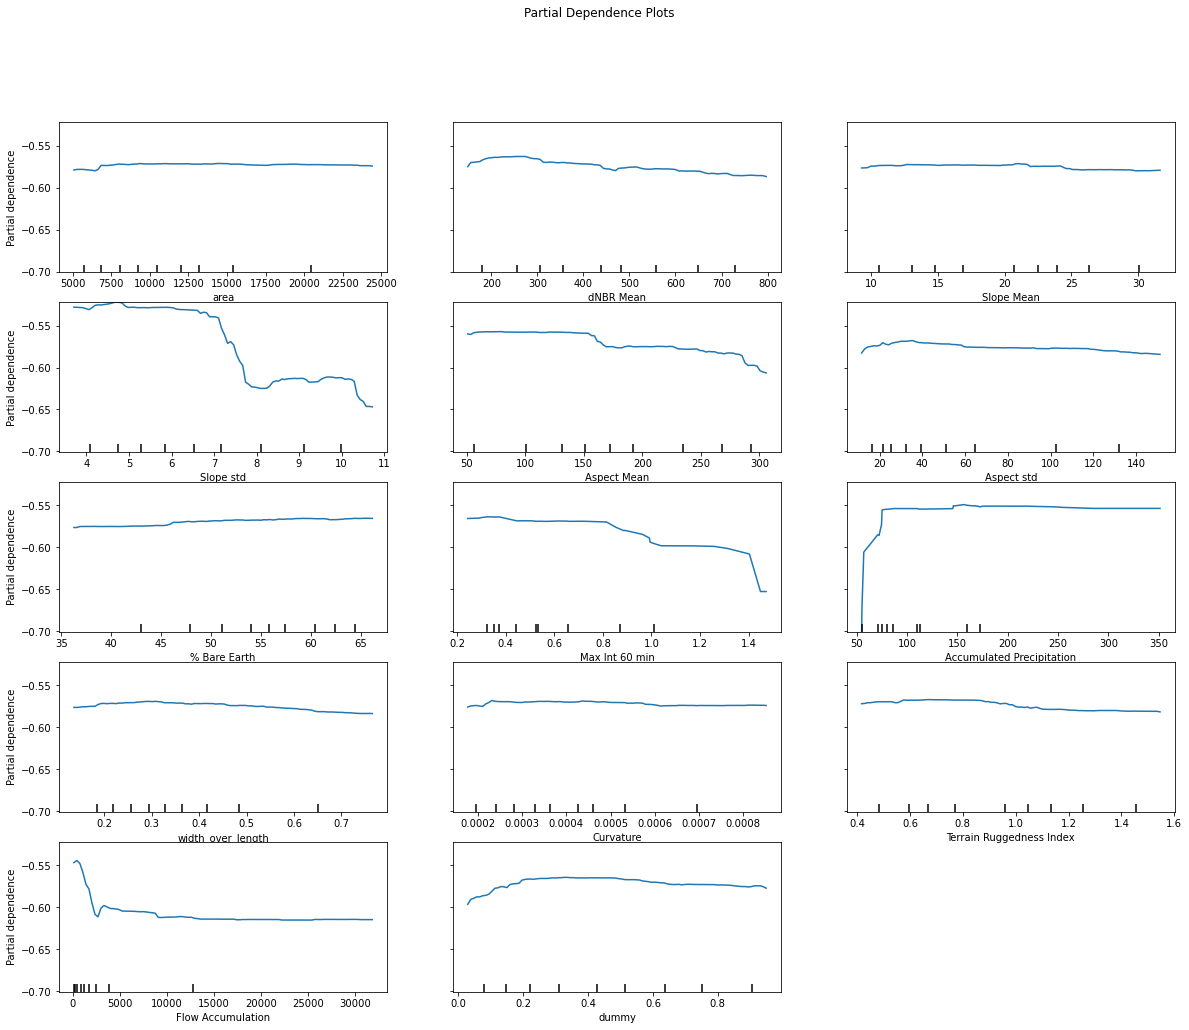

In [364]:
#Gini Impurity Feature Importance Ranking
rfut.plot_feature_importances(model, X.columns)

feature_list = range(0, len(X.columns))
rfut.partial_dependence_plots(model, X_train, feature_list)